#### On a 24 threads CPU

In [1]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                24
On-line CPU(s) list:   0-23
Thread(s) per core:    1
Core(s) per socket:    12
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 63
Stepping:              2
CPU MHz:               2594.000
BogoMIPS:              5187.59
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              30720K
NUMA node0 CPU(s):     0,2,4,6,8,10,12,14,16,18,20,22
NUMA node1 CPU(s):     1,3,5,7,9,11,13,15,17,19,21,23


In [1]:
# !ls -hl|grep csv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from time import time, ctime

from sklearn.metrics import accuracy_score, classification_report, classification, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, StratifiedShuffleSplit

from helper import plot_confusion_matrix, plot_confusion_matrix2
dim=lambda *x: [i.shape for i in x]

In [2]:
%%time
df = pd.read_csv('./preprocessed.csv')
print df.shape

(49260, 748)
CPU times: user 2.95 s, sys: 243 ms, total: 3.19 s
Wall time: 3.19 s


In [4]:
pd.options.display.max_columns=20
df.head(3)

,username,fname.gender,username_split_predict,last,last_two,first,first2,nchar,vowels.pct,digits.pct,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,b,bi,7,0.428571,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,A,Ar,9,0.222222,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,female,n,an,o,ok,9,0.444444,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0


In [5]:
X = df.iloc[:,2:].values
print X.shape
y = df.iloc[:,1].map({'male':1,'female':0}).values
print y.shape

(49260, 746)
(49260,)


#### label encoding

In [6]:
%%time
# Encoding the Independent Variable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

for i in range(5):
    i=str(i)
    exec("labelencoder_X_{} = LabelEncoder()".format(i))
    exec("X[:, {}] = labelencoder_X_{}.fit_transform(X[:, {}])".format(i,i,i))

XX=X.copy()

CPU times: user 672 ms, sys: 36 ms, total: 708 ms
Wall time: 707 ms


#### one hot encoding

In [7]:
%%time
print X.shape
onehotencoder = OneHotEncoder(categorical_features = range(6))
X = onehotencoder.fit_transform(X).toarray()
print X.shape

(49260, 746)
(49260, 4505)
CPU times: user 1.26 s, sys: 474 ms, total: 1.73 s
Wall time: 1.73 s


#### train_test split for testing model

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   random_state=7)
dim(X_train, X_test, y_train, y_test)

[(34482, 4505), (14778, 4505), (34482,), (14778,)]

#### normalize

In [9]:
%%time
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# fit on training set
X_train = sc.fit_transform(X_train)
# only transform on test set
X_test = sc.transform(X_test)
print dim(X_train,X_test, y_train, y_test)

[(34482, 4505), (14778, 4505), (34482,), (14778,)]
CPU times: user 2.43 s, sys: 1.25 s, total: 3.68 s
Wall time: 3.68 s


In [10]:
%%time
from sklearn.preprocessing import StandardScaler
sc2 = StandardScaler()
# nomalize on entire data set
X = sc2.fit_transform(X)

CPU times: user 2.88 s, sys: 1.53 s, total: 4.41 s
Wall time: 4.41 s


In [11]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import RFE

from xgboost import XGBClassifier

https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/

In [12]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier,\
ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier

from mlxtend.classifier import StackingClassifier, StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector

from sklearn.pipeline import make_pipeline
import numpy as np

### feature selection

In [13]:
%%time
m1 = AdaBoostClassifier().fit(X_train, y_train)
index1= pd.Series(m1.feature_importances_).sort_values(ascending=False)[:X_train.shape[1]/4*3].index

m2 = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=2, n_jobs=-1).fit(X_train, y_train)
index2= pd.Series(m2.feature_importances_).sort_values(ascending=False)[:X_train.shape[1]/4*3].index

m3 = XGBClassifier(nthread=-1, max_depth=24, min_child_weight=0.9, colsample_bytree=0.9,
                       scale_pos_weight= 0.9, reg_alpha=0.6).fit(X_train, y_train)
index3= pd.Series(m3.feature_importances_).sort_values(ascending=False)[:X_train.shape[1]/5*4].index

CPU times: user 33min 29s, sys: 2.98 s, total: 33min 32s
Wall time: 2min 57s


### Cross validation 

https://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/

In [14]:
%%time

RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

clf1 = AdaBoostClassifier()
clf2 = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=2, n_jobs=-1)
clf3 = XGBClassifier(nthread=-1, max_depth=24,
                        min_child_weight=0.9, colsample_bytree=0.9,
                       scale_pos_weight= 0.9, reg_alpha=0.6)
clf4 = BaggingClassifier(n_jobs=-1, n_estimators=50)
clf5 = ExtraTreesClassifier(n_jobs=-1, bootstrap=True, n_estimators=100)
lr = LogisticRegression(solver='lbfgs', n_jobs=-1)

pipe1 = make_pipeline(ColumnSelector(cols=index1), clf1)
pipe2 = make_pipeline(ColumnSelector(cols=index2), clf2)
pipe3 = make_pipeline(ColumnSelector(cols=index3), clf3)

sclf = StackingCVClassifier(classifiers=[ pipe1, pipe2, pipe3, clf4, clf5], 
                          meta_classifier=lr,
                          use_probas=True )



print('5-fold cross validation:\n')

if __name__ == '__main__':
    
    stack3 = []
    for clf, label in zip([pipe1, pipe2, pipe3,  clf4, clf5,  sclf], 
                          ['AdaBoost', 
                           'Random Forest', 
                           'Xgboost',
                           'Bagging',
                           'ExtraTrees',
                           'Stacking']):

        scores = model_selection.cross_val_score(clf, X, y, 
#                                                  n_jobs=-1,
                                                  cv=5, scoring='accuracy')
        stack3.append([label, scores, scores.mean(), scores.std()])
        print("Accuracy: %0.4f (+/- %0.4f) [%s]" 
              % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.8241 (+/- 0.0007) [AdaBoost]
Accuracy: 0.8254 (+/- 0.0012) [Random Forest]
Accuracy: 0.8294 (+/- 0.0013) [Xgboost]
Accuracy: 0.8263 (+/- 0.0021) [Bagging]
Accuracy: 0.8275 (+/- 0.0014) [ExtraTrees]
Accuracy: 0.8324 (+/- 0.0013) [Stacking]
CPU times: user 11h 14min 52s, sys: 3min 3s, total: 11h 17min 56s
Wall time: 1h 49min 22s


In [19]:
stack3

[['AdaBoost',
  array([ 0.82330255,  0.82511165,  0.82369062,  0.82480715,  0.82377424]),
  0.82413724059457305,
  0.00069659244788790732],
 ['Random Forest',
  array([ 0.82543388,  0.8271417 ,  0.82561916,  0.82551766,  0.8234697 ]),
  0.82543641972839021,
  0.0011675585922005214],
 ['Xgboost',
  array([ 0.82786968,  0.83130329,  0.83038977,  0.82947625,  0.82793625]),
  0.8293950480423421,
  0.0013485006838588496],
 ['Bagging',
  array([ 0.82370852,  0.82978076,  0.82754771,  0.82511165,  0.82549995]),
  0.82632971561985524,
  0.002118303878138736],
 ['ExtraTrees',
  array([ 0.82736222,  0.82764921,  0.83008526,  0.82673569,  0.82580449]),
  0.82752737398014931,
  0.0014268857567794379],
 ['Stacking',
  array([ 0.83101593,  0.83455136,  0.83252132,  0.83302883,  0.83098163]),
  0.83241981253942343,
  0.0013389511043863211]]

### Stacking test model on 70% training data 

In [15]:
%%time

RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

clf1 = AdaBoostClassifier()
clf2 = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=2, n_jobs=-1)
clf3 = XGBClassifier(nthread=-1, max_depth=24,
                        min_child_weight=0.9, colsample_bytree=0.9,
                       scale_pos_weight= 0.9, reg_alpha=0.6)
clf4 = BaggingClassifier(n_jobs=-1, n_estimators=50)
clf5 = ExtraTreesClassifier(n_jobs=-1, bootstrap=True, n_estimators=100)
lr = LogisticRegression(solver='lbfgs', n_jobs=-1)

pipe1 = make_pipeline(ColumnSelector(cols=index1),
                      clf1)
pipe2 = make_pipeline(ColumnSelector(cols=index2),
                      clf2)
pipe3 = make_pipeline(ColumnSelector(cols=index3),
                      clf3)


sclf = StackingCVClassifier(classifiers=[pipe1, pipe2, pipe3, clf4, clf5], 
                          meta_classifier=lr,
                          use_probas=True )

sclf.fit(X_train, y_train)

CPU times: user 1h 6min 46s, sys: 17.3 s, total: 1h 7min 4s
Wall time: 10min 30s


In [16]:
%%time
pred = sclf.predict(X_test)
print pred

[1 1 1 ..., 1 1 1]
CPU times: user 26.2 s, sys: 1.95 s, total: 28.2 s
Wall time: 28.1 s


#### highest accuracy so far, on train test split with 70% trainning data of random_seed=7

In [17]:
accuracy_score(y_test, pred)

0.83962647178237926

Confusion matrix, without normalization
[[  419  2244]
 [  126 11989]]


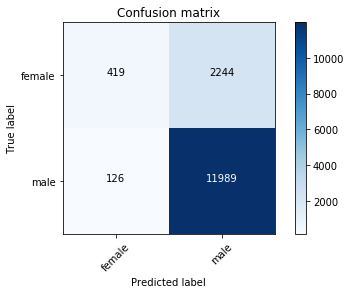

In [18]:
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=['female','male'])

#### predict on probabilities

In [21]:
%%time
pred_prob = sclf.predict_proba(X_test)
print pred_prob

[[ 0.21375638  0.78624362]
 [ 0.11533226  0.88466774]
 [ 0.16580005  0.83419995]
 ..., 
 [ 0.23172206  0.76827794]
 [ 0.17568238  0.82431762]
 [ 0.22243512  0.77756488]]
CPU times: user 25.9 s, sys: 1.94 s, total: 27.9 s
Wall time: 27.7 s


### Stacking final model on all data

In [20]:
### all data 
#X, y